# Homework 05

## Due Tuesday, March 29th at 11:59 P.M.

Jordan V. Pino

OCNG 689

Dr. Robert Hetland and Dr. Kristen Thyng

22 March 2016

In [1]:
%matplotlib inline
import numpy as np # imports!
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import shapely.geometry
import shapely.ops
from scipy import spatial
from scipy import interpolate
import scipy.interpolate
import pandas
import shapefile

### 1. Flyover states

_[This is very similar to the exercise done in class. This is a continuation.]_

What states do you see when you fly from LA (airport code LAX) to NYC (airport code EWR)?

> LAX: 33.9425° N, 118.4081° W

> EWR: 40.6925° N, 74.1686° W

Load in the `states_21basic` shapefile using these commands:

    from mpl_toolkits.basemap import Basemap
    m = Basemap(llcrnrlon=-150.,llcrnrlat=20.,
            urcrnrlon=-50.,urcrnrlat=50.,
            rsphere=(6378137.00,6356752.3142),
            resolution='l',projection='merc',
            lat_0=40.,lon_0=-100.,lat_ts=20.)
    m.readshapefile('../materials/states_21basic/states', 'states')

The boundary information for all of the states is now held in an attribute of the map object `m.states`, which is a list of lists of x-y pairs denoting the boundaries. Next use the `m.gcpoints` function to get the points along the great circle path. Convert all of these things into Shapely objects, and check for intersections. Add a buffer of 100km to the flight path to see what states you might potentially see along the way. Use this analysis to provide the following:

1. Create and display a map that shows the flight path, with the states that are seen along the flight path clearly highlighted in some way.

2. Use the information in m.states_info to extract and print a list containing the names of the states seen, with unique names. (see `np.unique`)


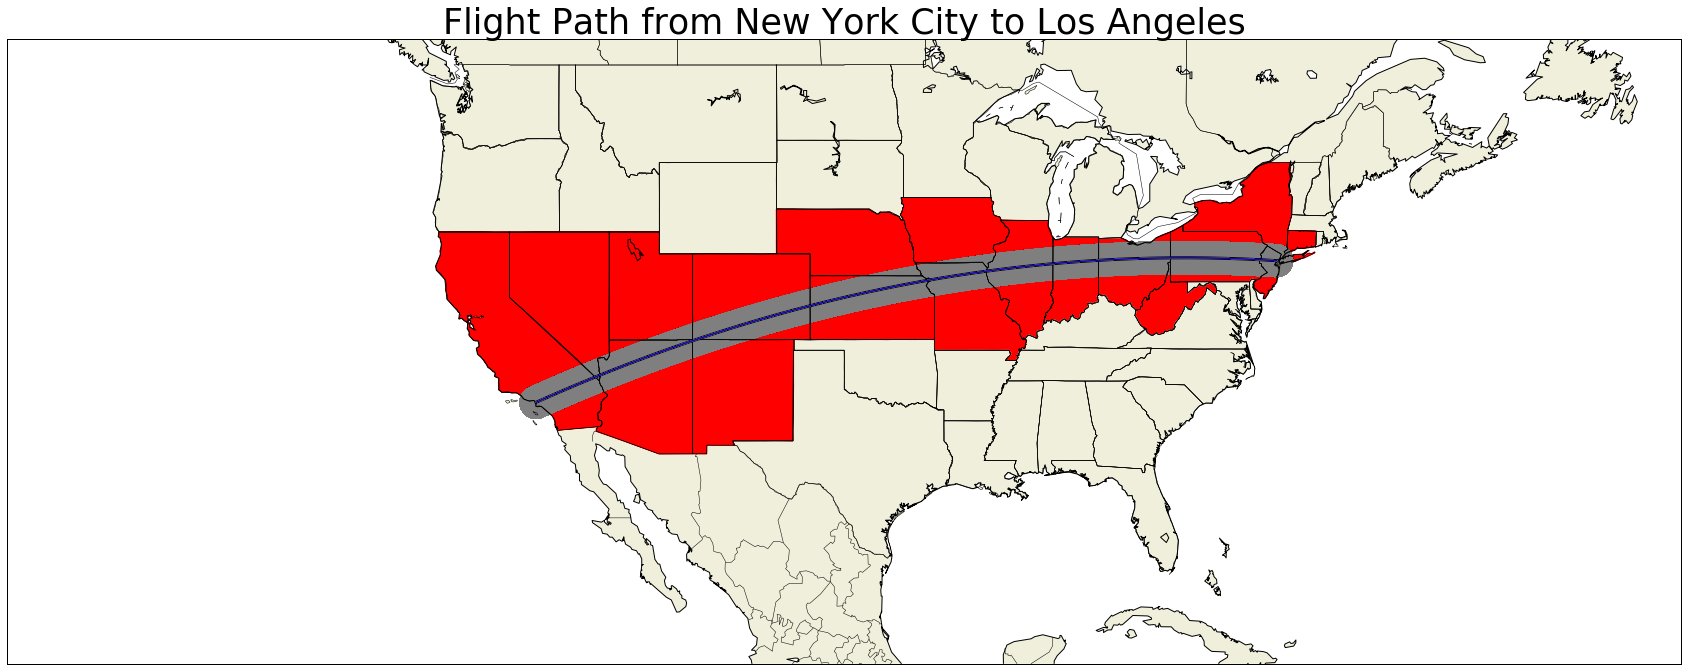

In [2]:
# Map showing flight path with states seen shaded in red. 100 km buffer also drawn.

plt.figure(figsize=(30,30))

from mpl_toolkits.basemap import Basemap
m = Basemap(llcrnrlon=-150.,llcrnrlat=20.,
        urcrnrlon=-50.,urcrnrlat=50.,
        rsphere=(6378137.00,6356752.3142),
        resolution='l',projection='merc',
        lat_0=40.,lon_0=-100.,lat_ts=20.)
m.readshapefile('states_21basic/states', 'states')
m.fillcontinents(color=[0.9375, 0.9375, 0.859375])
m.drawcoastlines()
m.drawcountries()
m.drawstates()

s, t = m.gcpoints(-118.4081,33.9425 ,-74.1686 ,40.6925 , 1000)
plt.plot(s,t,'k',lw=3)
plt.title('Flight Path from New York City to Los Angeles', size =35)

point=[]
for i in range(0,len(s)):
    point.append(shapely.geometry.Point(s[i], t[i]))
line = shapely.geometry.LineString(point).buffer(100000) # 100 km buffer added!

polys=[]
for state in m.states:
    polys.append(shapely.geometry.Polygon(state))
List=[]
for i in range(len(polys)):
    if polys[i].intersects(line):
        color = 'red'
        List.append(m.states_info[i]['STATE_NAME'])
    else:
        color = [0.9375, 0.9375, 0.859375]
    coords = shapely.ops.cascaded_union(polys[i].boundary).coords[:]
    x, y = zip(*coords)
    plt.fill(x, y, color=color)
    plt.fill(*line.boundary.xy, color='gray', alpha=0.9)
    plt.plot(s, t, '-')

In [3]:
# List of states seen!

print(np.unique(List)) 

['Arizona' 'California' 'Colorado' 'Connecticut' 'Illinois' 'Indiana'
 'Iowa' 'Kansas' 'Missouri' 'Nebraska' 'Nevada' 'New Jersey' 'New Mexico'
 'New York' 'Ohio' 'Pennsylvania' 'Utah' 'West Virginia']


### 2. Area in a Voronoi diagram

Given the series of points:

     np.array([[ 0.77354201,  0.34072038],
               [ 0.43807549,  0.93001924],
               [ 0.5624092 ,  0.79438991],
               [ 0.02536295,  0.46180244],
               [ 0.59533179,  0.07522803],
               [ 0.47867418,  0.70302822],
               [ 0.30371564,  0.83135442],
               [ 0.5856915 ,  0.16340903],
               [ 0.14700491,  0.60268997],
               [ 0.97098631,  0.51692456]])
               
create a Voronoi diagram, and calculate the area contained in the finite regions. What fraction of the total area is at least 0.001 unit away from any boundary? 0.01 away? And 0.1 away?


The area of the finite region is 1.0138912213334281!
The area with a .01 buffer is 0.09244245663939883!
The area with a .001 buffer is 0.8652536153511616!
The area with a .0001 buffer is 0.986090261784083!


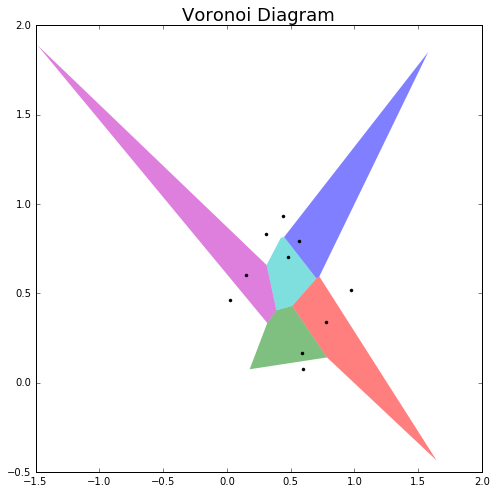

In [4]:
# Plot the diagram!

plt.figure(figsize=(8,8))

points = np.array([[ 0.77354201,  0.34072038],
           [ 0.43807549,  0.93001924],
           [ 0.5624092 ,  0.79438991],
           [ 0.02536295,  0.46180244],
           [ 0.59533179,  0.07522803],
           [ 0.47867418,  0.70302822],
           [ 0.30371564,  0.83135442],
           [ 0.5856915 ,  0.16340903],
           [ 0.14700491,  0.60268997],
           [ 0.97098631,  0.51692456]])

vor = spatial.Voronoi(points)

for indices in vor.regions:
    if not indices: continue     # check for empty regions
    if -1 in indices: continue   # region includes a vertex out of the diagram (the region goes to infinity)
    plt.fill(vor.vertices[indices, 0], vor.vertices[indices, 1], edgecolor='none', alpha=0.5)

plt.plot(points[:, 0], points[:, 1], '.k') 
plt.title('Voronoi Diagram', size=18)

# Calculate the areas!

lines = [shapely.geometry.LineString(vor.vertices[line]) for line in vor.ridge_vertices if -1 not in line]

poly = []
area=0
B01=0
B001=0
B0001=0

for poly in shapely.ops.polygonize(lines):
    polys.append(poly)
    area+=poly.area
    B01+=poly.buffer(-0.1).area
    B001+=poly.buffer(-0.01).area
    B0001+=poly.buffer(-0.001).area
    
print('The area of the finite region is ' + str(area) + '!')  
print('The area with a .01 buffer is ' + str(B01/area) + '!')
print('The area with a .001 buffer is ' + str(B001/area) + '!')
print('The area with a .0001 buffer is ' + str(B0001/area) + '!')

### 3. 2D interpolation

Data (found in `python4geosciences/data/MS03_L15.txt`) gathered from a field cruise out of the TAMU Oceanography department is randomly located in space (that is, unstructured) because of the nature of the measurement: the instrument is lowered into the water from a ship, and is brought up and down through the water column as the ship moves to get a sampling of the fields.

Read in the data file and plot the temperature in a `scatter` plot as a function of depth and latitude. Next, interpolate the temperature data to be on a uniform grid (to make it structured). Now, plot it using `contourf`, which requires structured data. Experiment with different spacing in your uniform grid, and with different numbers of contours to see how the results change, and choose values that provide a nice-looking image which closely resembles the original data.

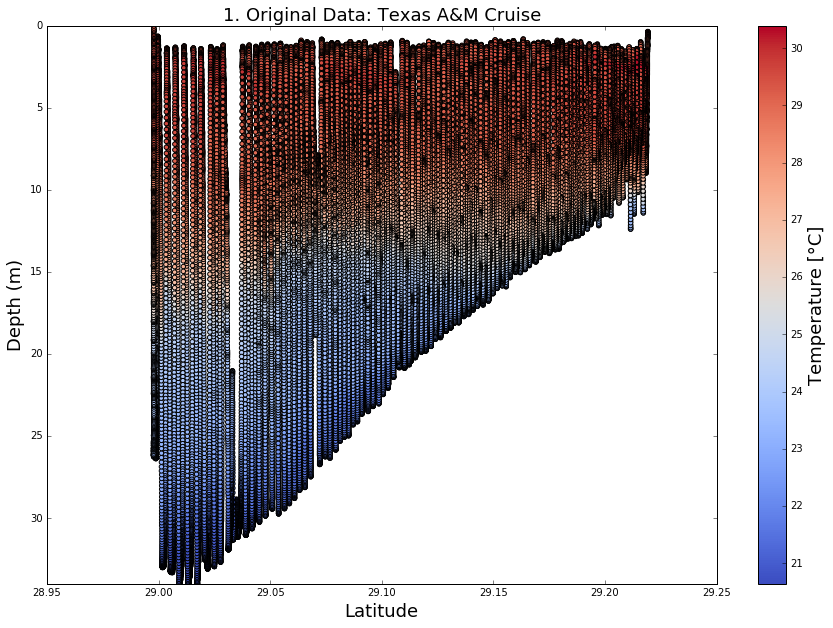

In [5]:
plt.figure(figsize=(15,10))

f = np.genfromtxt('MS03_L15.txt', skip_header=114) 
lat = f[:,0]
temp = f[:,15]
dep = f[:,2]

cb = plt.scatter(lat, dep, c=temp, cmap='coolwarm')
plt.gca().invert_yaxis()
a = plt.colorbar(cb)
a.set_label('Temperature [°C]', size=18)
plt.ylabel("Depth (m)", size=18)
plt.xlabel('Latitude', size=18)
plt.ylim((34,0))
plt.title('1. Original Data: Texas A&M Cruise', size=18)

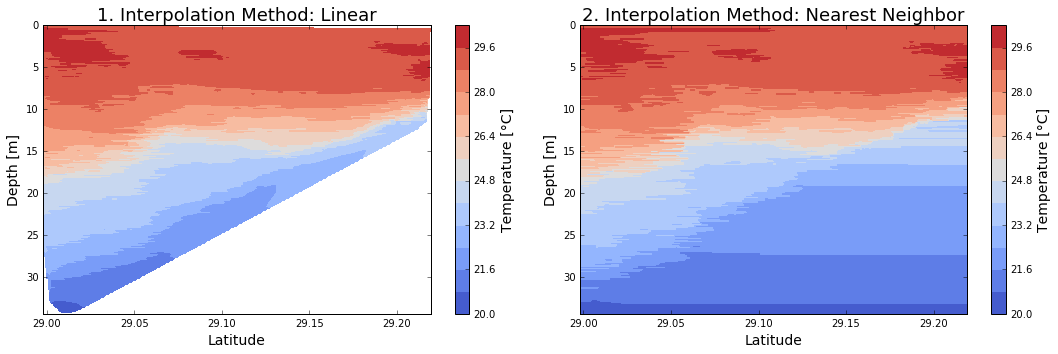

In [6]:
fig = plt.figure(figsize=(16, 3))

# Interpolate the data!

xi, yi = np.linspace(lat.min(), lat.max(), 300), np.linspace(dep.min(), dep.max(), 300)
xi, yi = np.meshgrid(xi, yi)

zi = scipy.interpolate.griddata((lat, dep), temp, (xi, yi), method='linear')
zi2 = scipy.interpolate.griddata((lat, dep), temp, (xi, yi), method='nearest')

fig = plt.figure(figsize=(15,5))

# 1. Interpolated data using LINEAR method!

ax0 = fig.add_subplot(1,2,1) 
cp0 = ax0.contourf(xi,yi,zi, 15, cmap='coolwarm')
cb0 = plt.colorbar(cp0, ax=ax0)
# axes[0].gca().invert_yaxis()
ax0.set_ylabel('Depth [m]', size=14)
ax0.set_xlabel('Latitude', size=14)
cb0.set_label('Temperature [°C]', size=14)
ax0.set_title('1. Interpolation Method: Linear', size=18)
ax0.invert_yaxis()

# 2. Interpolated data using NEAREST NEIGHBOR method!

ax1 = fig.add_subplot(1,2,2) 
cp1 = ax1.contourf(xi,yi,zi2, 15, cmap='coolwarm')
cb1 = plt.colorbar(cp1, ax=ax1)
ax1.set_ylabel('Depth [m]', size=14)
ax1.set_xlabel('Latitude', size=14)
cb1.set_label('Temperature [°C]', size=14)
ax1.set_title('2. Interpolation Method: Nearest Neighbor', size=18)
ax1.invert_yaxis()

fig.tight_layout()

### 4. (Grad) Area of Greenland and Australia in different projections

Set up Basemap instances of the following projections: Mercator, Robinson, and Mollweide; make sure that all three projections are set up to show both Greenland and Australia at the same time (this is necessary for Mercator in particular). Plot them side-by-side to see how they compare.

Next, read in the shape files for Greenland and Australia, found in the `data` directory; you can do this with something like the following (but you might need to change the directory path):

> m.readshapefile('../python4geosciences/data/GRL_adm_shp/GRL_adm0', 'greenland', drawbounds=False)
> m.readshapefile('../python4geosciences/data/AUS_adm_shp/AUS_adm0', 'australia', drawbounds=False)

where `m` is a `Basemap` instance. This gives you a series of polygons that make up each country, saved in `m.greenland` and `m.australia`. Find the area of the two countries in each projection and compare them. What is the area of Australia relative to the area of Greenland for each projection, and how does this compare to what it is in reality?

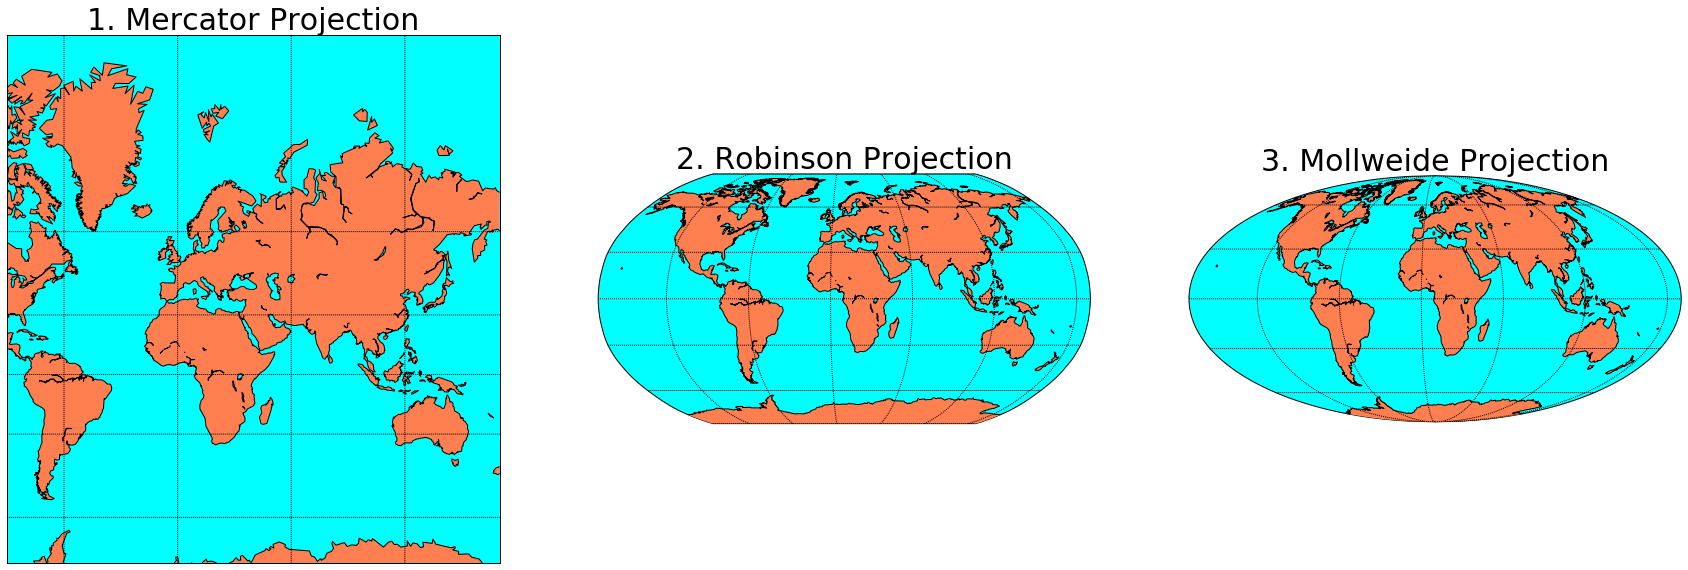

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(30,20))

# 1. Mercador Projection

axes[0].set_title("1. Mercator Projection", size=30)
mer = Basemap(projection='merc',llcrnrlat=-70,urcrnrlat=85,\
            llcrnrlon=-90,urcrnrlon=170,lat_ts=20,resolution='c', ax=axes[0])

mer.drawmapboundary(fill_color='aqua')
mer.fillcontinents(color='coral',lake_color='aqua')
mer.drawcoastlines()
mer.drawparallels(np.arange(-90.,91.,30.))
mer.drawmeridians(np.arange(-180.,181.,60.))

# 2. Robinson Projection

axes[1].set_title("2. Robinson Projection", size=30)
rob = Basemap(projection='robin', lon_0 = 10, lat_0 = 50, ax=axes[1])

rob.drawmapboundary(fill_color='aqua')
rob.fillcontinents(color='coral',lake_color='aqua')
rob.drawcoastlines()
rob.drawparallels(np.arange(-90.,120.,30.))
rob.drawmeridians(np.arange(0.,420.,60.))

# 3. Mollweide Projection

axes[2].set_title("3. Mollweide Projection", size=30)
mol = Basemap(projection='moll', lon_0 = 10, lat_0 = 50, ax=axes[2])

mol.drawmapboundary(fill_color='aqua')
mol.fillcontinents(color='coral',lake_color='aqua')
mol.drawcoastlines()
mol.drawparallels(np.arange(-90.,120.,30.))
mol.drawmeridians(np.arange(0.,420.,60.))

plt.show()

In [8]:
# Areas using Mercador Projection!

mer.readshapefile('AUS_adm0', 'australia', drawbounds=False)
A=0
for state in mer.australia:
    A+=shapely.geometry.Polygon(state).area * 0.000001 # Convert to kilometers squared!
    
print('Australia is ' + str(A) + ' km (squared) in the Mercador projection!')

mer.readshapefile('GRL_adm0', 'greenland', drawbounds=False)
G=0
for state in mer.greenland:
    G+=shapely.geometry.Polygon(state).area * 0.000001 # Convert to kilometers squared!
    
print('Greenland is ' + str(G) + ' km (squared) in the Mercador projection!')

# Areas using Robinson Projection!

rob.readshapefile('AUS_adm0', 'australia', drawbounds=False)
AA=0
for state in rob.australia:
    AA+=shapely.geometry.Polygon(state).area * 0.000001 # Convert to kilometers squared!
    
print('Australia is ' + str(AA) + ' km (squared) in the Robinson projection!')

rob.readshapefile('GRL_adm0', 'greenland', drawbounds=False)
GG=0
for state in rob.greenland:
    GG+=shapely.geometry.Polygon(state).area * 0.000001 # Convert to kilometers squared!
    
print('Greenland is ' + str(GG) + ' km (squared) in the Robinson projection!')

# Areas using Mollweide Projection!

mol.readshapefile('AUS_adm0', 'australia', drawbounds=False)
AAA=0
for state in mol.australia:
    AAA+=shapely.geometry.Polygon(state).area * 0.000001 # Convert to kilometers squared!
    
print('Australia is ' + str(AAA) + ' km (squared) in the Mollweide projection!')

mol.readshapefile('GRL_adm0', 'greenland', drawbounds=False)
GGG=0
for state in mol.greenland:
    GGG+=shapely.geometry.Polygon(state).area * 0.000001 # Convert to kilometers squared!
    
print('Greenland is ' + str(GGG) + ' km (squared) in the Mollweide projection!') 

Australia is 8501235.310688509 km (squared) in the Mercador projection!
Greenland is 30789355.371843927 km (squared) in the Mercador projection!
Australia is 6791690.519402715 km (squared) in the Robinson projection!
Greenland is 3423077.331843127 km (squared) in the Robinson projection!
Australia is 7699609.269222028 km (squared) in the Mollweide projection!
Greenland is 2134440.8616081257 km (squared) in the Mollweide projection!


Notes:

Australia = 7.692 million km${^2}$

Greenland = 2.166 million km${^2}$

1. The Mercador projection stretches Greenland to seem MUCH larger than Australia. However, in realitiy, Austrailia is larger!
2. Thus, Mercador projection is best used for areas in the middle latutides, and away from polar regions.
3. The Robinson projection is much better, but distortion near the polar regions is apparent.
4. The Mollweide projection is the best, since it's an equal-area projection.